In [ ]:
!pip install gekko

In [1]:
from gekko import GEKKO
import numpy as np
import random
from baconshor import *
import sys
import os
from contextlib import contextmanager

In [23]:
#surpress the print statement from the solver

@contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout  # Backup current stdout
        sys.stdout = devnull  # Redirect stdout to devnull (suppress)
        try:
            yield
        finally:
            sys.stdout = old_stdout  # Restore original stdout
# settings ----
d=5
num_qubits =d**2
num_stabilizers =(d - 1)**2
p = 0.08666666666666666

ps = {i: p for i in range(num_qubits)}

# grid = random_error_grid(d,p)
print("ErrorGrid: ")

grid = create_grid(5)
add_y_error(grid, [4,21])


Print(grid)

Cs = construct_stabilizers(d,grid)
# print("Stabilizer Measurements: ")
# print(Cs)

# set up gekko ----
m = GEKKO(remote=False)
m.options.SOLVER = 1  # APOPT is an MINLP solver
# optional solver settings with APOPT
m.solver_options = [
    "minlp_maximum_iterations 10000",  # minlp iterations with integer solution
    "minlp_max_iter_with_int_sol 10",  # treat minlp as nlp
    "minlp_as_nlp 0",  
    # nlp sub-problem max iterations
    "nlp_maximum_iterations 50",  # 1 = depth first, 2 = breadth first
    "minlp_branch_method 1",  # maximum deviation from whole number
    "minlp_integer_tol 0.05",  # covergence tolerance
    "minlp_gap_tol 0.01",
    "print_level 0",
]


# set up variables ---
Es = {}
for i in range(num_qubits):
    Es[i] = m.Var(
        value=random.randint(0,1), lb=0, ub=1, integer=True
    )

Ks = {}
for k in Cs.keys():
    Ks[k] = m.Var(
        value=random.randint(0,1), lb=0, integer=True
    )


# Objective ---
m.Obj(
    -m.sum(
        [
            np.log(ps[j]) * Es[j]  + np.log(1 - ps[j]) * (1 - Es[j])
            for j in range(num_qubits)
        ]
    )
)


# Constraints ---

for key, val in Cs.items():
    # i, j,k,l,o,n = key
    # m.Equation(Es[i] + Es[j] - 2 * Ks[key] == (1 - val)/2)
    m.Equation(m.sum([Es[i] for i in key]) - 2 * Ks[key] == (1 - val)/2) #automatically sums over all the qubits in the stabilizer key


m.solve()

print("Solver's Guess: ")
predicted = solver_to_grid(d, Es)
Print(predicted)
print("Was the solver correct? ")
print(solver_accuracy(d, grid, predicted))


ErrorGrid: 
0 0 0 1 0 
0 0 0 0 0 
0 0 0 0 0 
0 0 0 0 0 
1 0 0 0 0 
 ----------------------------------------------------------------
 APMonitor, Version 1.0.3
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            9
   Constants    :            0
   Variables    :           67
   Intermediates:            0
   Connections  :          114
   Equations    :           34
   Residuals    :           34
 
 Number of state variables:             67
 Number of total equations: -           42
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :             25
 
 ----------------------------------------------
 Steady State Optimization with APOPT Solver
 ----------------------------------------------
 Unknown option: print_level
Iter:     1 I:  0 Tm:      0.00 NLPi:    3 Dpth:    0 Lvs:    3 Obj:  6.9

Graph

In [36]:
#surpress the print statement from the solver

@contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout  # Backup current stdout
        sys.stdout = devnull  # Redirect stdout to devnull (suppress)
        try:
            yield
        finally:
            sys.stdout = old_stdout  # Restore original stdout
# settings ----
d=3
num_qubits =d**2
num_stabilizers =(d - 1)**2


physical_error_probs = np.linspace(0.01, 0.70, num=50)#physical error probs
logical_error_probs=[]
for p in physical_error_probs: 
    count = 0 #number of correct guesses from solver
    for i in range(500):

        ps = {i: p for i in range(num_qubits)}

        grid = random_error_grid(d,p)
        # print("ErrorGrid: ") 
        # Print(grid)

        Cs = construct_stabilizers(d,grid)
        # print("Stabilizer Measurements: ")
        # print(Cs)

        # set up gekko ----
        m = GEKKO(remote=False)
        m.options.SOLVER = 1  # APOPT is an MINLP solver
        # optional solver settings with APOPT
        m.solver_options = [
            "minlp_maximum_iterations 500",  # minlp iterations with integer solution
            "minlp_max_iter_with_int_sol 10",  # treat minlp as nlp
            "minlp_as_nlp 0",  
            # nlp sub-problem max iterations
            "nlp_maximum_iterations 50",  # 1 = depth first, 2 = breadth first
            "minlp_branch_method 1",  # maximum deviation from whole number
            "minlp_integer_tol 0.05",  # covergence tolerance
            "minlp_gap_tol 0.01",
            "print_level 0",
        ]


        # set up variables ---
        Es = {}
        for i in range(num_qubits):
            Es[i] = m.Var(
                value=random.randint(0,1), lb=0, ub=1, integer=True
            )

        Ks = {}
        for k in Cs.keys():
            Ks[k] = m.Var(
                value=random.randint(0,1), lb=0, integer=True
            )


        # Objective ---
        m.Obj(
            -m.sum(
                [
                    np.log(ps[j]) * Es[j]  + np.log(1 - ps[j]) * (1 - Es[j])
                    for j in range(num_qubits)
                ]
            )
        )


        # Constraints ---

        for key, val in Cs.items():
            i, j,k,l,o,n = key
            # m.Equation(Es[i] + Es[j] - 2 * Ks[key] == (1 - val)/2)
            m.Equation(m.sum([Es[i] for i in key]) - 2 * Ks[key] == (1 - val)/2) #automatically sums over all the qubits in the stabilizer key

        with suppress_stdout():
            m.solve()

        # print("Solver's Guess: ")
        # Print_Solver(d, Es)
        # print("Was the solver correct? ")
        # print(solver_accuracy(d, grid,Es))
        if(solver_accuracy(d, grid,solver_to_grid(d,Es))!= True):
            count+=1
    logical_error_probs.append(count/500)
phys_three = physical_error_probs
log_three = logical_error_probs
    


d=3

APOPT solver

No handles with labels found to put in legend.


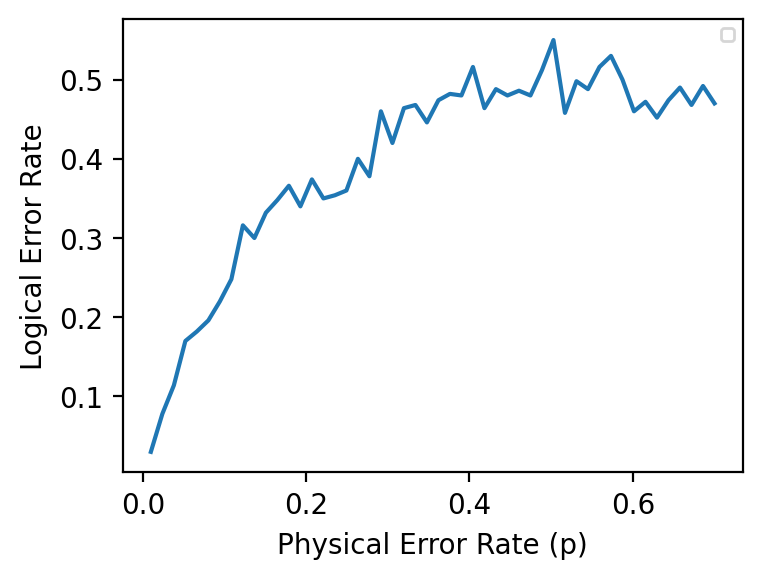

In [38]:
plot(phys_three, log_three)

d=5

APOPT

In [26]:
#surpress the print statement from the solver

@contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout  # Backup current stdout
        sys.stdout = devnull  # Redirect stdout to devnull (suppress)
        try:
            yield
        finally:
            sys.stdout = old_stdout  # Restore original stdout
try:
# settings ----
    d=5
    num_qubits =d**2
    num_stabilizers =(d - 1)**2


    physical_error_probs = np.linspace(0.01, 0.70, num=50)#physical error probs
    logical_error_probs=[]
    for p in physical_error_probs: 
        count = 0 #number of correct guesses from solver
        for i in range(500):

            ps = {i: p for i in range(num_qubits)}

            grid = random_error_grid(d,p)
            # print("ErrorGrid: ") 
            # Print(grid)

            Cs = construct_stabilizers(d,grid)
            # print("Stabilizer Measurements: ")
            # print(Cs)

            # set up gekko ----
            m = GEKKO(remote=False)
            m.options.SOLVER = 1  # APOPT is an MINLP solver
            # optional solver settings with APOPT
            m.solver_options = [
                "minlp_maximum_iterations 10000",  # minlp iterations with integer solution
                "minlp_max_iter_with_int_sol 10",  # treat minlp as nlp
                "minlp_as_nlp 0",  
                # nlp sub-problem max iterations
                "nlp_maximum_iterations 50",  # 1 = depth first, 2 = breadth first
                "minlp_branch_method 1",  # maximum deviation from whole number
                "minlp_integer_tol 0.05",  # covergence tolerance
                "minlp_gap_tol 0.01",
                "print_level 0",
            ]


            # set up variables ---
            Es = {}
            for i in range(num_qubits):
                Es[i] = m.Var(
                    value=random.randint(0,1), lb=0, ub=1, integer=True
                )

            Ks = {}
            for k in Cs.keys():
                Ks[k] = m.Var(
                    value=random.randint(0,1), lb=0, integer=True
                )


            # Objective ---
            m.Obj(
                -m.sum(
                    [
                        np.log(ps[j]) * Es[j]  + np.log(1 - ps[j]) * (1 - Es[j])
                        for j in range(num_qubits)
                    ]
                )
            )


            # Constraints ---

            for key, val in Cs.items():
                # i, j,k,l,o,n = key
                # m.Equation(Es[i] + Es[j] - 2 * Ks[key] == (1 - val)/2)
                m.Equation(m.sum([Es[i] for i in key]) - 2 * Ks[key] == (1 - val)/2) #automatically sums over all the qubits in the stabilizer key

            with suppress_stdout():
                m.solve(disp=True)

            # print("Solver's Guess: ")
            # Print_Solver(d, Es)
            # print("Was the solver correct? ")
            # print(solver_accuracy(d, grid,Es))
            if(solver_accuracy(d, grid,solver_to_grid(d,Es))!= True):
                count+=1
        logical_error_probs.append(count/500)
except Exception as e:
  # Code to handle any exception
  print(f"An error occurred: {e}")
  print(p)
  Print(grid)
  print(Cs)
  print(Es)
    


No handles with labels found to put in legend.


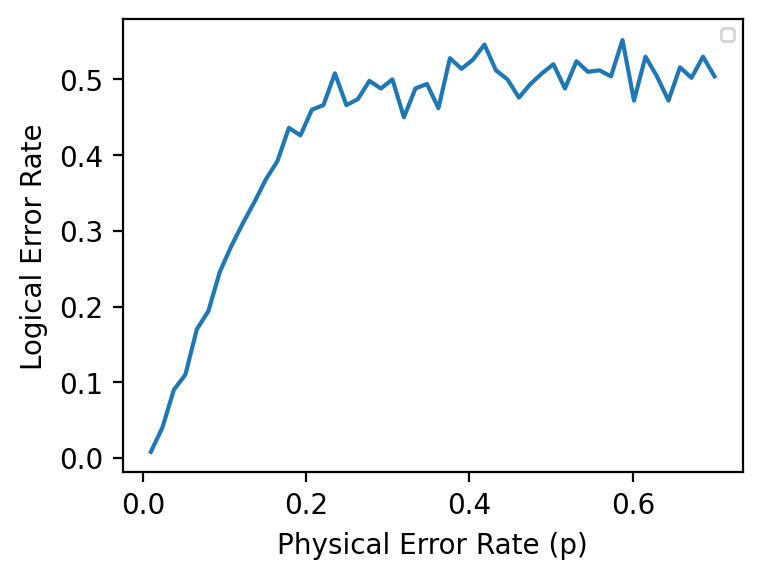

In [34]:
phys_five= physical_error_probs
log_five = logical_error_probs
plot(phys_five, log_five)

In [43]:
#surpress the print statement from the solver

@contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout  # Backup current stdout
        sys.stdout = devnull  # Redirect stdout to devnull (suppress)
        try:
            yield
        finally:
            sys.stdout = old_stdout  # Restore original stdout
try:
# settings ----
    d=7
    num_qubits =d**2
    num_stabilizers =(d - 1)**2


    physical_error_probs = np.linspace(0.01, 0.70, num=50)#physical error probs
    logical_error_probs=[]
    for p in physical_error_probs: 
        count = 0 #number of correct guesses from solver
        for i in range(500):

            ps = {i: p for i in range(num_qubits)}

            grid = random_error_grid(d,p)
            # print("ErrorGrid: ") 
            # Print(grid)

            Cs = construct_stabilizers(d,grid)
            # print("Stabilizer Measurements: ")
            # print(Cs)

            # set up gekko ----
            m = GEKKO(remote=False)
            m.options.SOLVER = 1  # APOPT is an MINLP solver
            # optional solver settings with APOPT
            m.solver_options = [
                "minlp_maximum_iterations 1000000",  # minlp iterations with integer solution
                "minlp_max_iter_with_int_sol 10",  # treat minlp as nlp
                "minlp_as_nlp 0",  
                # nlp sub-problem max iterations
                "nlp_maximum_iterations 50",  # 1 = depth first, 2 = breadth first
                "minlp_branch_method 1",  # maximum deviation from whole number
                "minlp_integer_tol 0.05",  # covergence tolerance
                "minlp_gap_tol 0.01",
                "print_level 0",
            ]


            # set up variables ---
            Es = {}
            for i in range(num_qubits):
                Es[i] = m.Var(
                    value=random.randint(0,1), lb=0, ub=1, integer=True
                )

            Ks = {}
            for k in Cs.keys():
                Ks[k] = m.Var(
                    value=random.randint(0,1), lb=0, integer=True
                )


            # Objective ---
            m.Obj(
                -m.sum(
                    [
                        np.log(ps[j]) * Es[j]  + np.log(1 - ps[j]) * (1 - Es[j])
                        for j in range(num_qubits)
                    ]
                )
            )


            # Constraints ---

            for key, val in Cs.items():
                # i, j,k,l,o,n = key
                # m.Equation(Es[i] + Es[j] - 2 * Ks[key] == (1 - val)/2)
                m.Equation(m.sum([Es[i] for i in key]) - 2 * Ks[key] == (1 - val)/2) #automatically sums over all the qubits in the stabilizer key

            with suppress_stdout():
                m.solve(disp=True)

            # print("Solver's Guess: ")
            # Print_Solver(d, Es)
            # print("Was the solver correct? ")
            # print(solver_accuracy(d, grid,Es))
            if(solver_accuracy(d, grid,solver_to_grid(d,Es))!= True):
                count+=1
        logical_error_probs.append(count/500)
except Exception as e:
  # Code to handle any exception
  print(f"An error occurred: {e}")
  print(p)
  Print(grid)
  print(Cs)
  print(Es)
    
phys_seven = physical_error_probs
log_seven = logical_error_probs

KeyboardInterrupt: 

No handles with labels found to put in legend.


[]

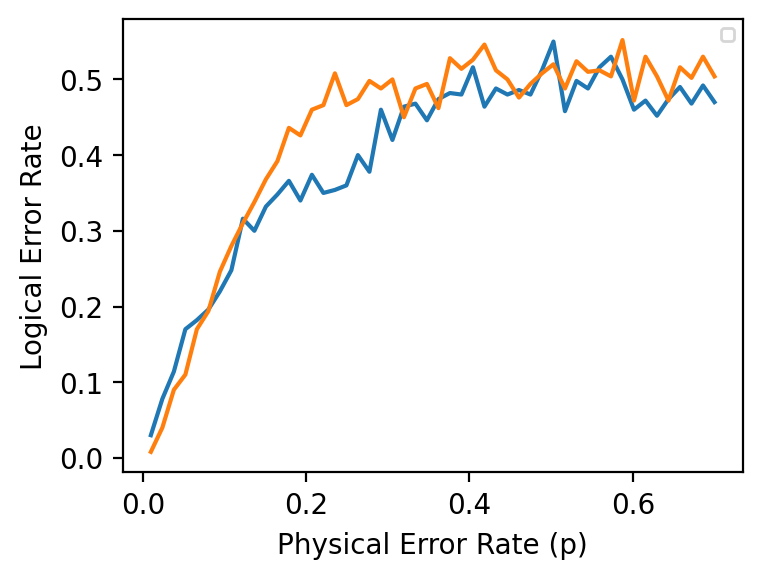

In [39]:
#BPOPT for 7 ad overlay 3,5,7
#try editing APOPT for 3,5,7 and overlay
all_logical_error_probs = [log_three, log_five]
fig,ax = plt.subplots(1,1,dpi=200,figsize = (4,3))
for log in all_logical_error_probs:
    ax.plot(phys_three,log)

ax.legend(fontsize=6)
ax.set_xlabel("Physical Error Rate (p)")
ax.set_ylabel("Logical Error Rate")
plt.plot()
